# Loading Packages

In [1]:
# !pip3 install torch==1.9.1+cu102 torchvision==0.10.1+cu102 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install imblearn

In [1]:
# Basic Python Packages
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Torch Packages
import torch
import torchvision
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

# ML Test and Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Other
import cv2
from tqdm import tqdm
from copy import deepcopy
from random import *

# Our functions
from processing_functions_2 import *

# Formatting
pd.set_option('max_colwidth', 1000)

In [2]:
xray_path = 'D:/dental_training_images/images/'
anomaly_path = 'D:/dental_training_images/labels/'
segmentation_path = 'D:/dental_training_images/segments/'

xray_filenames = os.listdir(xray_path)
anomaly_filenames = os.listdir(anomaly_path)
segmentation_filenames = os.listdir(segmentation_path)

xray_file_stripped = [x[:-4] for x in xray_filenames]
anomaly_file_stripped = [x[:-4] for x in anomaly_filenames]
segmentation_file_stripped = [x[:-4] for x in segmentation_filenames]
final_list = set(xray_file_stripped).intersection(anomaly_file_stripped)
final_list = set(final_list).intersection(segmentation_file_stripped)
final_list = list(final_list)

In [5]:
len(final_list)

484

In [6]:
xray_path = 'D:/dental_training_images/images_test/'
anomaly_path = 'D:/dental_training_images/labels_test/'
segmentation_path = 'D:/dental_training_images/segments_test/'

xray_filenames = os.listdir(xray_path)
anomaly_filenames = os.listdir(anomaly_path)
segmentation_filenames = os.listdir(segmentation_path)

xray_file_stripped = [x[:-4] for x in xray_filenames]
anomaly_file_stripped = [x[:-4] for x in anomaly_filenames]
segmentation_file_stripped = [x[:-4] for x in segmentation_filenames]
final_list = set(xray_file_stripped).intersection(anomaly_file_stripped)
final_list = set(final_list).intersection(segmentation_file_stripped)
final_list = list(final_list)

In [7]:
len(final_list)

525

# EDA

In [3]:
train_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/train_data_final.csv')
train_clahe_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/train_data_clahe_final.csv')

valid_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/valid_data_pano0_6.csv')
valid_clahe_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/valid_clahe_data_pano0_6.csv')

In [3]:
train_df.groupby('anomaly_codes').count()

,Unnamed: 0,file_path
anomaly_codes,,
0.0,1377,1377
1.0,205,205
2.0,30,30
3.0,14,14
4.0,53,53
5.0,61,61
6.0,108,108
7.0,9033,9033
8.0,155,155


In [4]:
train_df.groupby('anomaly_codes').count()

,Unnamed: 0,Unnamed: 0.1,file_path
anomaly_codes,,,
0.0,1316,1316,1316
1.0,184,184,184
2.0,26,26,26
3.0,13,13,13
4.0,43,43,43
5.0,45,45,45
6.0,74,74,74
7.0,9033,9033,9033
8.0,155,155,155


In [14]:
train_clahe_df.groupby('anomaly_codes').count()

,Unnamed: 0,file_path
anomaly_codes,,
0.0,1316,1316
1.0,184,184
2.0,26,26
3.0,13,13
4.0,43,43
5.0,45,45
6.0,74,74
7.0,9033,9033
8.0,155,155


In [7]:
valid_df.groupby('anomaly_codes').count()

,Unnamed: 0,file_path
anomaly_codes,,
0.0,344,344
1.0,51,51
2.0,8,8
3.0,3,3
4.0,14,14
5.0,15,15
6.0,27,27
7.0,2258,2258
8.0,39,39


In [5]:
valid_clahe_df.groupby('anomaly_codes').count()

,Unnamed: 0,file_path
anomaly_codes,,
0.0,344,344
1.0,51,51
2.0,8,8
3.0,3,3
4.0,14,14
5.0,15,15
6.0,27,27
7.0,2258,2258
8.0,39,39


# Class Definitions

## _TeethDataLoaders_

In [4]:
class TeethDataLoader(data.Dataset):
    
    def __init__(self, path_to_df, anomalies_to_include, check_augments, augments_to_include):
        """
        path_to_df: the path to the main data frame ex. ~/Documents/Dental/segmented_data.csv
        anomalies_to_include: list of anomlies based on code ex. [0, 1, 2, 3, 4, 5, 6, 7, 8]
        augments_to_include: list of augment bools to include as list of 1s and Os 
                             ex. [1, 1, 1, 1] == [rotation, flip, noise, blur]
                             ex. [1, 1, 0, 0] == [rotation, flip, no noise, no blur]
        """
        # Read in data
        df = pd.read_csv(path_to_df)
        
        # Filter out which anomalies
        df = df[df['anomaly_codes'].isin(anomalies_to_include)]
        
        if check_augments:
            # Filter out which augmentations to include
            include_rotations = augments_to_include[0]
            include_flips = augments_to_include[1]
            include_noise = augments_to_include[2]
            include_blur = augments_to_include[3]

            if(include_rotations == 0):
                df = df[df['is_rotated'] == 0]
            else:
                df = filter_rotation(df, [[0, 20], [160, 200], [340, 360]])
            if(include_flips == 0):
                df = df[df['is_flipped'] == 0]
            if(include_noise == 0):
                df = df[df['is_noise'] == 0]
            if(include_blur == 0):
                df = df[df['is_blur'] == 0]

        self.images, self.labels = df['file_path'].tolist(), df['anomaly_codes'].tolist()
        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = cv2.imread(self.images[index])     # loads image from file
        img = cv2.resize(img, (224, 224))        # resize image to 224x224
        img = np.array(img, dtype=np.float32)    # change data type to float
        img = (img / 255.)                       # normalize colors to be 0-1
        img = img[:, :, (2, 1, 0)]               # reorder RGB
        img = torchvision.transforms.ToTensor()(img)  # convert to tensor
        label = self.labels[index]               # Make label
        
        return img.float(), torch.FloatTensor([label]) # returns tensor of modified image and label

In [5]:
class TeethDataLoader_wSMOTE(data.Dataset): 
    
    def __init__(self, train_dataloader, under_strategy, over_strategy):
        self.images, self.labels = SMOTE_Balance(train_dataloader, under_strategy, over_strategy)
           
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]               # class # 
        
        return img.float(), torch.FloatTensor([label]) # returns tensor of modified image and label

## Defining the Model Classes and Layers

In [6]:
class BasicConv(nn.Module):
    # initialize class
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, 
                 padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        # def conv layer, in_planes/out_planes = size of features
        self.conv = nn.Conv2d(in_planes, out_planes, 
                              kernel_size=kernel_size, stride=stride, 
                              padding=padding, dilation=dilation,
                              groups=groups, bias=bias)
        # batch normalization - normalization of the layers' inputs by re-centering and re-scaling
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        # ReLu activation
        self.relu = nn.ReLU() if relu else None

    # create feed-forward network for conv layer
    def forward(self, x):
        x = self.conv(x)           # only 1 layer
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x
 
    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1) # reshape to flatten tensor which is necessary in order to pass data into a linear layer
                                     # add -1
                                     # no flatten function in pytorch so need to create it

            
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

    
def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

       
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

       
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.network_type = network_type
        # different model config between ImageNet and CIFAR 
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        self.fc = nn.Linear(512 * block.expansion, num_classes)
        #self.fc = nn.Linear(512 * block.expansion, 1) # linear is output of probability distributions
        self.softmax = torch.nn.Sigmoid()
        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        if self.network_type == "ImageNet":
            x = self.avgpool(x)
        else:
            x = F.avg_pool2d(x, 4)
            
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        #return F.normalize(x, dim=-1)
        return self.softmax(x)
    
def ResidualNet(network_type, depth, num_classes, att_type):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [5, 18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)
        
    elif depth == 5:
        model = ResNet(BasicBlock, [1, 1, 2, 1], network_type, num_classes, att_type)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

## Define Train and Valid Functions

In [8]:
best_accuracy = 0

def train(train_loader, model, classes, optimizer, epoch):
    model.train()
    running_mse = 0
    batch_idx = 0
    correct, total = 0, 0
    confusion_matrix = torch.zeros(classes, classes)
 
    pd, gt = [], []
    for (x, y) in tqdm(train_loader):
        batch_idx += 1
        x = x.to(device) # move data to GPU
        y = y.to(device) # move data to GPU

        out = model(x)
        criterion = nn.CrossEntropyLoss()
        #criterion = nn.BCELoss()                    # binary cross entropy loss
        loss = criterion(out, y.squeeze(1).long())
        #loss = criterion(out.squeeze(1), y.squeeze(1)) # calculate loss based on pred output vs actuals y, 
                                                       # .squeeze removes dimensions of 1
        running_mse += loss.item() 
        optimizer.zero_grad()        # start gradient at 0
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        #predicted = (out.data > 0.5).int()

        for p in predicted:
            pd.append(p)
        for g in y.squeeze(1):
            gt.append(g)

        total += y.squeeze(1).size(0)
        correct += (predicted == y.squeeze(1)).sum().item()
        for t, p in zip(y.squeeze(1).view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
    
    pd = torch.as_tensor(pd).numpy()
    gt = torch.as_tensor(gt).numpy()

    running_mse = running_mse / batch_idx
    print('Epoch %d, loss = %.4f, batch_idx= %d' % (epoch, running_mse, batch_idx))
    print('Epoch: %d Accuracy of the Train Images: %f' %(epoch, 100 * correct / total))
    print('Confusion Matrix\n', np.round(confusion_matrix.cpu().numpy(), 2))
    print('Classification Report\n', classification_report(gt, pd))
    return running_mse, 100*correct/total
    

def valid(valid_loader, model, classes, epoch):
    global best_accuracy
    model.eval()
    correct, total = 0, 0
    running_mse = 0
    batch_idx = 0
    confusion_matrix = torch.zeros(classes, classes)
    pd, gt = [], []
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            batch_idx += 1
            x = x.to(device)
            y = y.to(device)

            out = model(x) # add .to(device) ???
            criterion = nn.CrossEntropyLoss()
            #criterion = nn.BCELoss()
            loss = criterion(out, y.squeeze(1).long())
            #loss = criterion(out.squeeze(1), y.squeeze(1))
            running_mse += loss.item()
            _, predicted = torch.max(out.data, 1)
            #predicted = (out.data > 0.5).int()

            for p in predicted:
                pd.append(p)
            for g in y.squeeze(1):
                gt.append(g)

            total += y.squeeze(1).size(0)
            correct += (predicted == y.squeeze(1)).sum().item()
            for t, p in zip(y.squeeze(1).view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    if best_accuracy < 100 * (correct/total):
        best_accuracy = 100 * (correct/total)
        
    pd = torch.as_tensor(pd).numpy()
    gt = torch.as_tensor(gt).numpy()
    
    running_mse = running_mse / batch_idx
    print('Epoch: %d Accuracy of the Valid Images: %f' %(epoch, 100 * correct / total))
    print('Confusion Matrix\n', np.round(confusion_matrix.cpu().numpy(), 2))
    print('Classification Report\n', classification_report(gt, pd))
    return running_mse, 100*correct/total

# GPU

In [9]:
# check if GPU available and assign it
torch.cuda.is_available()
device = torch.device('cuda', 1)
# device = torch.device('cpu') # this switches to CPU for debugging
device

device(type='cuda', index=1)

# Make Datasets and Train Models

In [10]:
# Global Variables for the Models
train_path_to_df = 'C:/Documents/Dental_Detection/data_csv/train_data_final.csv'
train_clahe_path_to_df = 'C:/Documents/Dental_Detection/data_csv/train_data_clahe_final.csv'
valid_path_to_df = 'C:/Documents/Dental_Detection/data_csv/valid_data_pano0_6.csv'
valid_clahe_path_to_df = 'C:/Documents/Dental_Detection/data_csv/valid_clahe_data_pano0_6.csv'
batch_size = 64
epochs = 30

## _Model 1 - No Clahe_

### Create dataset/loaders

In [11]:
anomalies_to_include_1 = [0, 1, 2, 3, 4, 5, 6, 7]
augments_to_include_1 = [0, 0, 0, 0]

num_classes_1 = len(anomalies_to_include_1)

train_dataset_1 = TeethDataLoader(train_path_to_df, anomalies_to_include_1, False, augments_to_include_1)
valid_dataset_1 = TeethDataLoader(valid_path_to_df, anomalies_to_include_1, False, augments_to_include_1)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_1 = np.array(range(len(train_dataset_1.labels)))
shuffle(train_idx_1)
valid_idx_1 = np.array(range(len(valid_dataset_1.labels)))
shuffle(valid_idx_1)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_1 = torch.utils.data.SubsetRandomSampler(train_idx_1)
valid_sampler_1 = torch.utils.data.SubsetRandomSampler(valid_idx_1)

# loads images associated with ids/samples from above
train_loader_1 = torch.utils.data.DataLoader(train_dataset_1, batch_size=batch_size, sampler=train_sampler_1)
valid_loader_1 = torch.utils.data.DataLoader(valid_dataset_1, batch_size=batch_size, sampler=valid_sampler_1)

### Balance Data

In [17]:
under_strategy = {0:1000, 1:184, 2:26, 3:13, 4:43, 5:45, 6:74, 7:1000}
over_strategy = {0:1000, 1:1000, 2:1000, 3:1000, 4:1000, 5:1000, 6:1000, 7:1000}

In [18]:
dataset_smote_1 = TeethDataLoader_wSMOTE(train_loader_1, under_strategy, over_strategy)
train_idx_1_smote = np.array(range(len(dataset_smote_1.labels)))

100%|██████████| 168/168 [1:32:08<00:00, 32.91s/it]


Transformed images for SMOTE
Undersampled
Performed SMOTE
Transformed images for Model


In [19]:
torch.save(dataset_smote_1, 'dataset_smote_FINAL.pth')

In [20]:
for i in range(0, 8):
    print(i, ":", dataset_smote_1.labels.tolist().count(i))

0 : 1000
1 : 1000
2 : 1000
3 : 1000
4 : 1000
5 : 1000
6 : 1000
7 : 1000


#### Start here to load in already run SMOTE

In [12]:
dataset_smote_1 = torch.load('dataset_smote_FINAL.pth')
train_idx_1_smote = np.array(range(len(dataset_smote_1.labels)))
shuffle(train_idx_1_smote)
train_sampler_1_smote = torch.utils.data.SubsetRandomSampler(train_idx_1_smote)
train_loader_smote_1 = torch.utils.data.DataLoader(dataset_smote_1, batch_size=batch_size, sampler=train_sampler_1_smote)

In [13]:
valid_dataset_1 = TeethDataLoader(valid_path_to_df, anomalies_to_include_1, False, augments_to_include_1)
valid_idx_1 = np.array(range(len(valid_dataset_1.labels)))
shuffle(valid_idx_1)
valid_sampler_1 = torch.utils.data.SubsetRandomSampler(valid_idx_1)
valid_loader_1 = torch.utils.data.DataLoader(valid_dataset_1, batch_size=batch_size, sampler=valid_sampler_1)

### Run & Save Model

In [14]:
model_1 = ResidualNet('ImageNet', 5, num_classes_1, 'CBAM')
model_1.to(device) # sends model to GPU
optimizer = optim.Adam(model_1.parameters(), lr=0.00003)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_10392/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_10392/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


In [15]:
epochs = 7
train_loss_1 = []
valid_loss_1 = []
train_acc_1 = []
valid_acc_1 = []

for epoch in range(1, epochs+1):
    train_epoch_loss, train_epoch_accuracy = train(train_loader_smote_1, model_1, num_classes_1, optimizer, epoch)
    valid_epoch_loss, val_epoch_accuracy = valid(valid_loader_1, model_1, num_classes_1, epoch)
    
    train_loss_1.append(train_epoch_loss)
    valid_loss_1.append(valid_epoch_loss)
    
    train_acc_1.append(train_epoch_accuracy)
    valid_acc_1.append(val_epoch_accuracy)

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:20<00:00,  6.18it/s]


Epoch 1, loss = 1.8616, batch_idx= 125
Epoch: 1 Accuracy of the Train Images: 41.100000
Confusion Matrix
 [[272.  88. 108. 182. 161.   7.  40. 142.]
 [ 18. 584. 154.  42. 121.   3.   3.  75.]
 [ 33. 201. 698.  15.  12.   5.   0.  36.]
 [ 20.  26.  16. 683. 124.   5.  25. 101.]
 [ 22.   4.   9. 149. 511.  46. 100. 159.]
 [ 10.   2.  29. 320. 336. 107.  55. 141.]
 [ 14.  17.  41. 291. 258.  32. 198. 149.]
 [ 42.  30.  91. 179. 312.  27.  84. 235.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.63      0.27      0.38      1000
         1.0       0.61      0.58      0.60      1000
         2.0       0.61      0.70      0.65      1000
         3.0       0.37      0.68      0.48      1000
         4.0       0.28      0.51      0.36      1000
         5.0       0.46      0.11      0.17      1000
         6.0       0.39      0.20      0.26      1000
         7.0       0.23      0.23      0.23      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.22it/s]


Epoch: 1 Accuracy of the Valid Images: 30.367647
Confusion Matrix
 [[222.   9.  32.  32.  12.   4.   3.  30.]
 [  9.  25.   8.   2.   5.   1.   0.   1.]
 [  0.   4.   4.   0.   0.   0.   0.   0.]
 [  2.   0.   0.   1.   0.   0.   0.   0.]
 [  3.   0.   0.   6.   1.   0.   1.   3.]
 [  7.   0.   1.   4.   0.   0.   0.   3.]
 [  4.   2.   4.   6.   0.   5.   0.   6.]
 [401.  43. 122. 541. 329. 184.  65. 573.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.34      0.65      0.45       344
         1.0       0.30      0.49      0.37        51
         2.0       0.02      0.50      0.04         8
         3.0       0.00      0.33      0.00         3
         4.0       0.00      0.07      0.01        14
         5.0       0.00      0.00      0.00        15
         6.0       0.00      0.00      0.00        27
         7.0       0.93      0.25      0.40      2258

    accuracy                           0.30      2720
   macro avg       0.20

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:18<00:00,  6.91it/s]


Epoch 2, loss = 1.7006, batch_idx= 125
Epoch: 2 Accuracy of the Train Images: 55.712500
Confusion Matrix
 [[694.  27.  11.  63.  68.  15.  45.  77.]
 [ 53. 739.  34.  19. 101.   6.  13.  35.]
 [ 57. 337. 604.   0.   0.   2.   0.   0.]
 [  6.  24.   0. 842.  11.  22.  64.  31.]
 [ 51.   6.   0.  63. 550.  91. 180.  59.]
 [ 27.   0.   0. 124. 281. 396.  94.  78.]
 [ 57.  15.   9. 144. 258.  57. 406.  54.]
 [122.  33.  19.  76. 279.  73. 172. 226.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67      1000
         1.0       0.63      0.74      0.68      1000
         2.0       0.89      0.60      0.72      1000
         3.0       0.63      0.84      0.72      1000
         4.0       0.36      0.55      0.43      1000
         5.0       0.60      0.40      0.48      1000
         6.0       0.42      0.41      0.41      1000
         7.0       0.40      0.23      0.29      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.60it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 2 Accuracy of the Valid Images: 25.073529
Confusion Matrix
 [[248.  20.  52.   0.  21.   1.   0.   2.]
 [  5.  31.   7.   0.   6.   1.   0.   1.]
 [  0.   5.   3.   0.   0.   0.   0.   0.]
 [  1.   0.   1.   0.   1.   0.   0.   0.]
 [  5.   0.   1.   0.   4.   1.   0.   3.]
 [  9.   0.   4.   0.   0.   1.   0.   1.]
 [  6.   3.   7.   0.   5.   4.   0.   2.]
 [610.  93. 411.   1. 664.  84.   0. 395.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.28      0.72      0.40       344
         1.0       0.20      0.61      0.31        51
         2.0       0.01      0.38      0.01         8
         3.0       0.00      0.00      0.00         3
         4.0       0.01      0.29      0.01        14
         5.0       0.01      0.07      0.02        15
         6.0       0.00      0.00      0.00        27
         7.0       0.98      0.17      0.30      2258

    accuracy                           0.25      2720
   macro avg       0.19

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:17<00:00,  7.08it/s]


Epoch 3, loss = 1.6017, batch_idx= 125
Epoch: 3 Accuracy of the Train Images: 65.387500
Confusion Matrix
 [[765.  30.   6.  13.  63.  16.  37.  70.]
 [ 47. 781.  28.   2.  84.   8.  12.  38.]
 [ 19. 212. 769.   0.   0.   0.   0.   0.]
 [  1.   9.   0. 960.   3.   2.   8.  17.]
 [ 40.   8.   0.  19. 605.  61. 230.  37.]
 [ 22.   0.   0.  10. 255. 581.  63.  69.]
 [ 60.  17.   5.  39. 257.  46. 507.  69.]
 [130.  36.  16.  35. 275.  80. 165. 263.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.71      0.77      0.73      1000
         1.0       0.71      0.78      0.75      1000
         2.0       0.93      0.77      0.84      1000
         3.0       0.89      0.96      0.92      1000
         4.0       0.39      0.60      0.48      1000
         5.0       0.73      0.58      0.65      1000
         6.0       0.50      0.51      0.50      1000
         7.0       0.47      0.26      0.34      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.45it/s]


Epoch: 3 Accuracy of the Valid Images: 35.330882
Confusion Matrix
 [[179.   5. 120.   0.  10.   3.   4.  23.]
 [  0.  25.  20.   0.   4.   1.   0.   1.]
 [  0.   2.   6.   0.   0.   0.   0.   0.]
 [  1.   0.   1.   0.   1.   0.   0.   0.]
 [  2.   0.   2.   0.   2.   2.   1.   5.]
 [  2.   0.   7.   0.   0.   0.   1.   5.]
 [  0.   1.  11.   0.   3.   4.   3.   5.]
 [148.  22. 663.   1. 414. 108. 156. 746.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.54      0.52      0.53       344
         1.0       0.45      0.49      0.47        51
         2.0       0.01      0.75      0.01         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.14      0.01        14
         5.0       0.00      0.00      0.00        15
         6.0       0.02      0.11      0.03        27
         7.0       0.95      0.33      0.49      2258

    accuracy                           0.35      2720
   macro avg       0.25

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:17<00:00,  7.05it/s]


Epoch 4, loss = 1.5312, batch_idx= 125
Epoch: 4 Accuracy of the Train Images: 72.800000
Confusion Matrix
 [[793.  33.   3.  10.  45.   9.  28.  79.]
 [ 29. 838.  20.   0.  58.  10.  11.  34.]
 [  0.  40. 960.   0.   0.   0.   0.   0.]
 [  0.   2.   0. 990.   0.   1.   3.   4.]
 [ 16.   6.   1.   6. 630.  42. 242.  57.]
 [ 21.   1.   0.   0. 201. 698.  26.  53.]
 [ 44.  23.   2.  10. 242.  27. 575.  77.]
 [119.  33.   8.  20. 233.  68. 179. 340.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      1000
         1.0       0.86      0.84      0.85      1000
         2.0       0.97      0.96      0.96      1000
         3.0       0.96      0.99      0.97      1000
         4.0       0.45      0.63      0.52      1000
         5.0       0.82      0.70      0.75      1000
         6.0       0.54      0.57      0.56      1000
         7.0       0.53      0.34      0.41      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.43it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 4 Accuracy of the Valid Images: 24.669118
Confusion Matrix
 [[246.   5.   5.   0.  39.  15.  17.  17.]
 [  4.  33.   2.   0.   3.   5.   3.   1.]
 [  1.   5.   2.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   2.   0.]
 [  2.   0.   0.   0.   6.   3.   2.   1.]
 [  2.   0.   0.   0.   1.   1.   5.   6.]
 [  0.   3.   1.   0.   9.   6.   4.   4.]
 [197.  51.  16.   0. 805. 368. 442. 379.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.54      0.72      0.62       344
         1.0       0.34      0.65      0.45        51
         2.0       0.08      0.25      0.12         8
         3.0       0.00      0.00      0.00         3
         4.0       0.01      0.43      0.01        14
         5.0       0.00      0.07      0.00        15
         6.0       0.01      0.15      0.02        27
         7.0       0.93      0.17      0.28      2258

    accuracy                           0.25      2720
   macro avg       0.24

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:17<00:00,  7.01it/s]


Epoch 5, loss = 1.4828, batch_idx= 125
Epoch: 5 Accuracy of the Train Images: 78.500000
Confusion Matrix
 [[822.  29.   1.   2.  30.   8.  29.  79.]
 [ 17. 886.  12.   1.  32.  12.   9.  31.]
 [  0.   5. 995.   0.   0.   0.   0.   0.]
 [  0.   1.   0. 996.   0.   0.   1.   2.]
 [  4.   1.   0.   5. 686.  25. 216.  63.]
 [ 24.   1.   0.   2.  97. 826.   6.  44.]
 [ 28.  26.   1.   2. 200.  11. 643.  89.]
 [117.  35.   6.  16. 167.  66. 167. 426.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.82      0.82      1000
         1.0       0.90      0.89      0.89      1000
         2.0       0.98      0.99      0.99      1000
         3.0       0.97      1.00      0.98      1000
         4.0       0.57      0.69      0.62      1000
         5.0       0.87      0.83      0.85      1000
         6.0       0.60      0.64      0.62      1000
         7.0       0.58      0.43      0.49      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.17it/s]


Epoch: 5 Accuracy of the Valid Images: 57.941176
Confusion Matrix
 [[2.070e+02 9.000e+00 7.000e+01 0.000e+00 1.000e+00 3.000e+00 0.000e+00
  5.400e+01]
 [2.000e+00 2.700e+01 1.700e+01 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 2.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [2.000e+00 1.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.000e+00]
 [1.000e+00 0.000e+00 5.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
  7.000e+00]
 [1.000e+00 1.000e+00 1.000e+01 0.000e+00 0.000e+00 6.000e+00 0.000e+00
  9.000e+00]
 [1.710e+02 4.600e+01 4.880e+02 1.200e+01 2.600e+01 1.720e+02 9.000e+00
  1.334e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.54      0.60      0.57       344
         1.0       0.31      0.53      0.39        51
         2.0       0.01      0.75      0.02         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:17<00:00,  6.98it/s]


Epoch 6, loss = 1.4427, batch_idx= 125
Epoch: 6 Accuracy of the Train Images: 83.800000
Confusion Matrix
 [[852.  22.   2.   0.  16.   4.  15.  89.]
 [  8. 920.   6.   1.  15.   4.   7.  39.]
 [  0.   4. 995.   0.   0.   0.   0.   1.]
 [  0.   0.   0. 999.   0.   0.   0.   1.]
 [  4.   0.   0.   2. 748.   6. 198.  42.]
 [ 25.   3.   0.   0.  11. 928.   6.  27.]
 [ 24.  25.   1.   0.  87.   6. 765.  92.]
 [118.  32.   7.  11. 101.  60. 174. 497.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      1000
         1.0       0.91      0.92      0.92      1000
         2.0       0.98      0.99      0.99      1000
         3.0       0.99      1.00      0.99      1000
         4.0       0.76      0.75      0.76      1000
         5.0       0.92      0.93      0.92      1000
         6.0       0.66      0.77      0.71      1000
         7.0       0.63      0.50      0.56      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.24it/s]


Epoch: 6 Accuracy of the Valid Images: 20.772059
Confusion Matrix
 [[2.170e+02 1.100e+01 5.000e+00 0.000e+00 4.500e+01 0.000e+00 5.400e+01
  1.200e+01]
 [0.000e+00 3.600e+01 1.000e+00 0.000e+00 5.000e+00 1.000e+00 7.000e+00
  1.000e+00]
 [0.000e+00 6.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00 8.000e+00
  1.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00 1.000e+00 7.000e+00
  3.000e+00]
 [0.000e+00 3.000e+00 1.000e+00 0.000e+00 7.000e+00 2.000e+00 1.200e+01
  2.000e+00]
 [1.390e+02 5.600e+01 1.800e+01 4.000e+00 6.820e+02 6.400e+01 1.003e+03
  2.920e+02]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.61      0.63      0.62       344
         1.0       0.32      0.71      0.44        51
         2.0       0.07      0.25      0.11         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:17<00:00,  6.99it/s]


Epoch 7, loss = 1.4085, batch_idx= 125
Epoch: 7 Accuracy of the Train Images: 87.787500
Confusion Matrix
 [[862.  14.   1.   1.  14.   5.  17.  86.]
 [ 14. 943.   2.   0.   2.   4.   2.  33.]
 [  0.   1. 999.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 998.   0.   0.   0.   2.]
 [  1.   0.   0.   1. 835.   1. 139.  23.]
 [ 22.   1.   0.   1.   1. 959.   2.  14.]
 [ 24.  22.   0.   0.  33.   5. 838.  78.]
 [116.  36.   5.   8.  47.  52. 147. 589.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.83      0.86      0.85      1000
         1.0       0.93      0.94      0.94      1000
         2.0       0.99      1.00      1.00      1000
         3.0       0.99      1.00      0.99      1000
         4.0       0.90      0.83      0.86      1000
         5.0       0.93      0.96      0.95      1000
         6.0       0.73      0.84      0.78      1000
         7.0       0.71      0.59      0.65      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.52it/s]


Epoch: 7 Accuracy of the Valid Images: 69.889706
Confusion Matrix
 [[2.99e+02 6.00e+00 2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.70e+01]
 [4.00e+00 4.10e+01 2.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 3.00e+00]
 [0.00e+00 7.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]
 [4.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+01]
 [5.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 9.00e+00]
 [1.00e+00 3.00e+00 1.00e+00 0.00e+00 3.00e+00 0.00e+00 0.00e+00 1.90e+01]
 [4.58e+02 1.06e+02 1.80e+01 2.00e+00 4.60e+01 2.30e+01 4.50e+01 1.56e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.39      0.87      0.54       344
         1.0       0.25      0.80      0.38        51
         2.0       0.04      0.12      0.06         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00     

In [25]:
PATH = 'model_1_smote_weights_FINAL_7.pth'
torch.save(model_1.state_dict(), PATH)

In [26]:
PATH = 'model_1_smote_FINAL_7.pth'
torch.save(model_1,PATH)

### Plot Results

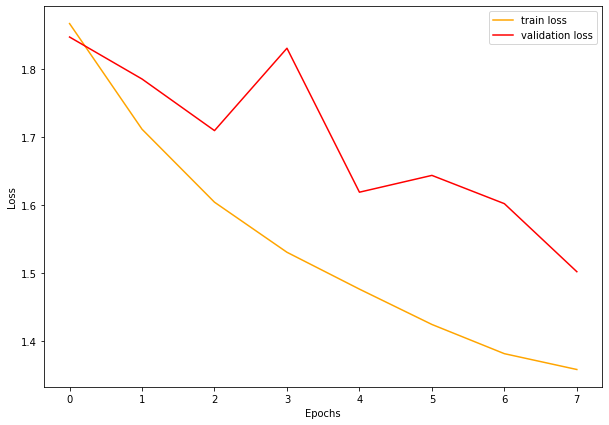

In [27]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss_1, color='orange', label='train loss')
plt.plot(valid_loss_1, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

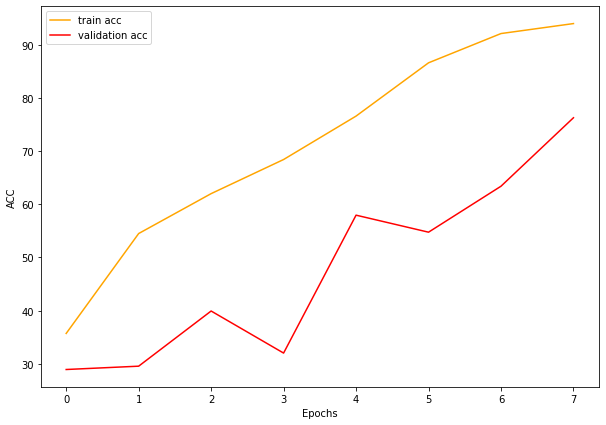

In [28]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_acc_1, color='orange', label='train acc')
plt.plot(valid_acc_1, color='red', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

## _Clahe Images_

#### Run SMOTE

In [12]:
train_dataset_clahe_1 = TeethDataLoader(train_clahe_path_to_df, anomalies_to_include_1, False, augments_to_include_1)
train_loader_clahe_1 = torch.utils.data.DataLoader(train_dataset_clahe_1, batch_size=batch_size, sampler=train_sampler_1)

In [13]:
under_strategy = {0:1000, 1:184, 2:26, 3:13, 4:43, 5:45, 6:74, 7:1000}
over_strategy = {0:1000, 1:1000, 2:1000, 3:1000, 4:1000, 5:1000, 6:1000, 7:1000}

In [14]:
dataset_smote_1_clahe = TeethDataLoader_wSMOTE(train_loader_clahe_1, under_strategy, over_strategy)

100%|██████████| 168/168 [1:22:54<00:00, 29.61s/it]


Transformed images for SMOTE
Undersampled
Performed SMOTE
Transformed images for Model


In [15]:
torch.save(dataset_smote_1_clahe, 'dataset_smote_1_clahe_FINAL.pth')

#### Load SMOTE

In [16]:
dataset_smote_1_clahe = torch.load('dataset_smote_1_clahe_FINAL.pth')
train_idx_1_clahe = np.array(range(len(dataset_smote_1_clahe.labels)))
shuffle(train_idx_1_clahe)
train_sampler_1_clahe = torch.utils.data.SubsetRandomSampler(train_idx_1_clahe)
train_loader_smote_1_clahe = torch.utils.data.DataLoader(dataset_smote_1_clahe, batch_size=batch_size, sampler=train_sampler_1_clahe)

In [17]:
valid_dataset_clahe_1 = TeethDataLoader(valid_clahe_path_to_df, anomalies_to_include_1, False, augments_to_include_1)
valid_loader_clahe_1 = torch.utils.data.DataLoader(valid_dataset_clahe_1, batch_size=batch_size, sampler=valid_sampler_1)

#### Train Model

In [30]:
model_1_clahe = ResidualNet('ImageNet', 34, num_classes_1, 'CBAM')
model_1_clahe.to(device) # sends model to GPU
optimizer_1_clahe = optim.Adam(model_1_clahe.parameters(), lr=0.00001)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_18540/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_18540/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


In [31]:
epochs = 15
train_loss_1_clahe = []
valid_loss_1_clahe = []
train_acc_1_clahe = []
valid_acc_1_clahe = []

for epoch in range(1, epochs+1):
    train_epoch_loss, train_epoch_accuracy = train(train_loader_smote_1_clahe, model_1_clahe, num_classes_1, optimizer_1_clahe, epoch)
    valid_epoch_loss, val_epoch_accuracy = valid(valid_loader_clahe_1, model_1_clahe, num_classes_1, epoch)
    
    train_loss_1_clahe.append(train_epoch_loss)
    valid_loss_1_clahe.append(valid_epoch_loss)
    
    train_acc_1_clahe.append(train_epoch_accuracy)
    valid_acc_1_clahe.append(val_epoch_accuracy)

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.47it/s]


Epoch 1, loss = 1.9232, batch_idx= 125
Epoch: 1 Accuracy of the Train Images: 35.825000
Confusion Matrix
 [[648. 109.  64.   0.  17. 153.   0.   9.]
 [195. 382.  49.   0. 131. 239.   1.   3.]
 [219. 150. 402.   0.   0. 229.   0.   0.]
 [140.  38.  18. 211.  86. 506.   1.   0.]
 [101.  29.  10.   0. 408. 438.  13.   1.]
 [151.  26.  21.   0.  59. 730.  12.   1.]
 [119.  90.  12.   2. 218. 482.  77.   0.]
 [397. 121.  83.   0.  75. 315.   1.   8.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.33      0.65      0.44      1000
         1.0       0.40      0.38      0.39      1000
         2.0       0.61      0.40      0.48      1000
         3.0       0.99      0.21      0.35      1000
         4.0       0.41      0.41      0.41      1000
         5.0       0.24      0.73      0.36      1000
         6.0       0.73      0.08      0.14      1000
         7.0       0.36      0.01      0.02      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.28it/s]


Epoch: 1 Accuracy of the Valid Images: 15.183824
Confusion Matrix
 [[2.840e+02 3.200e+01 7.000e+00 0.000e+00 3.000e+00 1.400e+01 0.000e+00
  4.000e+00]
 [3.400e+01 1.100e+01 3.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  1.000e+00]
 [7.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [9.000e+00 1.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.000e+00]
 [1.200e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.000e+00]
 [2.100e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.000e+00]
 [1.362e+03 2.660e+02 1.290e+02 4.000e+00 1.240e+02 2.520e+02 4.000e+00
  1.170e+02]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.16      0.83      0.27       344
         1.0       0.03      0.22      0.06        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.45it/s]


Epoch 2, loss = 1.7312, batch_idx= 125
Epoch: 2 Accuracy of the Train Images: 58.562500
Confusion Matrix
 [[734.  85.  30.   1.  21.  45.   8.  76.]
 [163. 563.  25.   4. 123.  76.   8.  38.]
 [ 97. 131. 746.   0.   0.  24.   0.   2.]
 [ 48.   0.   8. 737.  31. 176.   0.   0.]
 [101.  11.   5.   0. 628. 217.  27.  11.]
 [124.   8.  16.   1.  50. 750.  42.   9.]
 [ 99.  50.  10.   3. 215. 286. 314.  23.]
 [389.  98.  99.   1.  87.  99.  14. 213.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.42      0.73      0.53      1000
         1.0       0.60      0.56      0.58      1000
         2.0       0.79      0.75      0.77      1000
         3.0       0.99      0.74      0.84      1000
         4.0       0.54      0.63      0.58      1000
         5.0       0.45      0.75      0.56      1000
         6.0       0.76      0.31      0.44      1000
         7.0       0.57      0.21      0.31      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.28it/s]


Epoch: 2 Accuracy of the Valid Images: 35.110294
Confusion Matrix
 [[2.710e+02 2.000e+01 5.000e+00 1.000e+00 3.000e+00 1.300e+01 2.000e+00
  2.900e+01]
 [2.800e+01 1.300e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [7.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  3.000e+00]
 [1.700e+01 4.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [1.087e+03 1.610e+02 1.500e+02 2.000e+00 7.400e+01 7.800e+01 3.600e+01
  6.700e+02]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.19      0.79      0.31       344
         1.0       0.07      0.25      0.10        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.44it/s]


Epoch 3, loss = 1.5992, batch_idx= 125
Epoch: 3 Accuracy of the Train Images: 72.412500
Confusion Matrix
 [[732.  61.  10.   0.  20.  20.   9. 148.]
 [109. 738.  13.   0.  32.  51.  11.  46.]
 [ 13. 148. 827.   0.   0.   2.   0.  10.]
 [ 16.   0.   0. 848.   0. 136.   0.   0.]
 [ 97.   9.   0.   0. 734.  72.  75.  13.]
 [100.   4.   1.   0.  10. 859.  21.   5.]
 [ 85.  31.   6.   0.  78. 130. 633.  37.]
 [322.  83.  54.   0.  51.  40.  28. 422.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.50      0.73      0.59      1000
         1.0       0.69      0.74      0.71      1000
         2.0       0.91      0.83      0.87      1000
         3.0       1.00      0.85      0.92      1000
         4.0       0.79      0.73      0.76      1000
         5.0       0.66      0.86      0.74      1000
         6.0       0.81      0.63      0.71      1000
         7.0       0.62      0.42      0.50      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.30it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 3 Accuracy of the Valid Images: 45.367647
Confusion Matrix
 [[2.92e+02 7.00e+00 0.00e+00 0.00e+00 3.00e+00 5.00e+00 2.00e+00 3.50e+01]
 [3.30e+01 9.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.00e+00]
 [7.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [8.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 6.00e+00]
 [1.10e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.00e+00]
 [1.80e+01 3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 6.00e+00]
 [1.13e+03 7.80e+01 3.10e+01 0.00e+00 4.20e+01 1.90e+01 2.50e+01 9.33e+02]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.19      0.85      0.32       344
         1.0       0.09      0.18      0.12        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00     

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.40it/s]


Epoch 4, loss = 1.4944, batch_idx= 125
Epoch: 4 Accuracy of the Train Images: 83.762500
Confusion Matrix
 [[724.  62.   4.   0.  14.   2.  14. 180.]
 [ 79. 835.   7.   0.   7.  13.  13.  46.]
 [  3.  78. 919.   0.   0.   0.   0.   0.]
 [  2.   0.   0. 989.   0.   9.   0.   0.]
 [ 54.   8.   0.   0. 885.  11.  31.  11.]
 [ 47.   4.   0.   0.   3. 940.   4.   2.]
 [ 56.  19.   0.   0.  21.  24. 847.  33.]
 [287.  59.  23.   0.  36.   9.  24. 562.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.58      0.72      0.64      1000
         1.0       0.78      0.83      0.81      1000
         2.0       0.96      0.92      0.94      1000
         3.0       1.00      0.99      0.99      1000
         4.0       0.92      0.89      0.90      1000
         5.0       0.93      0.94      0.94      1000
         6.0       0.91      0.85      0.88      1000
         7.0       0.67      0.56      0.61      1000

    accuracy                          

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.16it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 4 Accuracy of the Valid Images: 52.426471
Confusion Matrix
 [[2.680e+02 1.200e+01 2.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  5.900e+01]
 [2.000e+01 2.300e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [6.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [1.100e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.800e+01 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [9.110e+02 9.000e+01 9.300e+01 0.000e+00 1.100e+01 8.000e+00 1.000e+01
  1.135e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.22      0.78      0.34       344
         1.0       0.18      0.45      0.26        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.40it/s]


Epoch 5, loss = 1.4203, batch_idx= 125
Epoch: 5 Accuracy of the Train Images: 89.850000
Confusion Matrix
 [[ 678.   44.    2.    1.    8.    0.    6.  261.]
 [  35.  928.    0.    0.    0.    0.    4.   33.]
 [   1.   11.  986.    0.    0.    0.    0.    2.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [  30.    0.    0.    0.  958.    0.    3.    9.]
 [   9.    0.    0.    0.    0.  990.    0.    1.]
 [  32.    6.    0.    0.    0.    2.  941.   19.]
 [ 222.   34.    8.    1.   14.    6.    8.  707.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.67      0.68      0.68      1000
         1.0       0.91      0.93      0.92      1000
         2.0       0.99      0.99      0.99      1000
         3.0       1.00      1.00      1.00      1000
         4.0       0.98      0.96      0.97      1000
         5.0       0.99      0.99      0.99      1000
         6.0       0.98      0.94      0.96      1000
         7.0       0.69      

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:07<00:00,  6.14it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 5 Accuracy of the Valid Images: 50.183824
Confusion Matrix
 [[2.880e+02 7.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
  4.700e+01]
 [2.400e+01 2.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [7.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [1.100e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.800e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [1.119e+03 5.300e+01 4.000e+00 0.000e+00 1.400e+01 8.000e+00 6.000e+00
  1.054e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.19      0.84      0.32       344
         1.0       0.26      0.43      0.33        51
         2.0       0.20      0.12      0.15         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch 6, loss = 1.3809, batch_idx= 125
Epoch: 6 Accuracy of the Train Images: 91.862500
Confusion Matrix
 [[ 705.   26.    0.    0.    4.    2.    2.  261.]
 [  23.  964.    2.    0.    0.    0.    1.   10.]
 [   0.    1.  999.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [  13.    0.    0.    0.  985.    0.    1.    1.]
 [   1.    0.    0.    0.    0.  999.    0.    0.]
 [  18.    1.    0.    0.    0.    0.  972.    9.]
 [ 228.   30.    3.    0.    9.    1.    4.  725.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.71      0.70      0.71      1000
         1.0       0.94      0.96      0.95      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       0.99      0.98      0.99      1000
         5.0       1.00      1.00      1.00      1000
         6.0       0.99      0.97      0.98      1000
         7.0       0.72      

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.17it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 6 Accuracy of the Valid Images: 52.169118
Confusion Matrix
 [[2.79e+02 1.10e+01 1.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+00 5.10e+01]
 [1.80e+01 2.90e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.00e+00]
 [6.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]
 [3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [8.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 6.00e+00]
 [1.10e+01 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [1.80e+01 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.00e+00]
 [9.91e+02 7.70e+01 2.70e+01 0.00e+00 1.10e+01 6.00e+00 3.60e+01 1.11e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.21      0.81      0.33       344
         1.0       0.24      0.57      0.34        51
         2.0       0.03      0.12      0.05         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00     

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch 7, loss = 1.3554, batch_idx= 125
Epoch: 7 Accuracy of the Train Images: 92.925000
Confusion Matrix
 [[ 691.   17.    1.    1.    3.    1.    2.  284.]
 [  10.  983.    0.    0.    0.    0.    0.    7.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   2.    0.    0.    0.  997.    0.    0.    1.]
 [   1.    0.    0.    0.    0.  999.    0.    0.]
 [   3.    0.    0.    0.    0.    0.  993.    4.]
 [ 203.   17.    1.    0.    2.    1.    5.  771.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.69      0.72      1000
         1.0       0.97      0.98      0.97      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       0.99      0.99      0.99      1000
         7.0       0.72      

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.21it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 7 Accuracy of the Valid Images: 55.404412
Confusion Matrix
 [[2.720e+02 1.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  5.900e+01]
 [1.400e+01 3.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [6.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [1.700e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [9.560e+02 6.400e+01 2.700e+01 0.000e+00 5.000e+00 2.000e+00 3.000e+00
  1.201e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.21      0.79      0.33       344
         1.0       0.29      0.65      0.40        51
         2.0       0.04      0.12      0.06         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch 8, loss = 1.3412, batch_idx= 125
Epoch: 8 Accuracy of the Train Images: 93.687500
Confusion Matrix
 [[ 745.    4.    0.    2.    1.    1.    0.  247.]
 [   4.  995.    0.    0.    0.    0.    0.    1.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   1.    0.    0.    0.  999.    0.    0.    0.]
 [   1.    0.    0.    0.    0.  999.    0.    0.]
 [   2.    0.    0.    0.    0.    0.  996.    2.]
 [ 223.   12.    0.    0.    2.    1.    1.  761.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      1000
         1.0       0.98      0.99      0.99      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       1.00      1.00      1.00      1000
         7.0       0.75      

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.16it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 8 Accuracy of the Valid Images: 60.257353
Confusion Matrix
 [[2.830e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.100e+01]
 [2.800e+01 1.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [6.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [1.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [8.910e+02 1.700e+01 4.000e+00 0.000e+00 3.000e+00 1.000e+00 0.000e+00
  1.342e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.23      0.82      0.36       344
         1.0       0.43      0.25      0.32        51
         2.0       0.20      0.12      0.15         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch 9, loss = 1.3313, batch_idx= 125
Epoch: 9 Accuracy of the Train Images: 93.950000
Confusion Matrix
 [[ 762.    3.    0.    0.    2.    1.    0.  232.]
 [   1.  998.    0.    0.    0.    0.    0.    1.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.]
 [   1.    0.    0.    0.    0.  999.    0.    0.]
 [   1.    0.    0.    0.    0.    0.  999.    0.]
 [ 229.    7.    1.    1.    0.    1.    3.  758.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.76      0.76      1000
         1.0       0.99      1.00      0.99      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       1.00      1.00      1.00      1000
         7.0       0.76      

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.23it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 9 Accuracy of the Valid Images: 56.507353
Confusion Matrix
 [[2.940e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.900e+01]
 [2.200e+01 2.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [7.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [1.700e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.000e+00]
 [1.003e+03 2.800e+01 2.000e+00 0.000e+00 2.000e+00 2.000e+00 1.000e+00
  1.220e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.22      0.85      0.34       344
         1.0       0.43      0.43      0.43        51
         2.0       0.33      0.12      0.18         8
         3.0

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch 10, loss = 1.3227, batch_idx= 125
Epoch: 10 Accuracy of the Train Images: 94.300000
Confusion Matrix
 [[ 800.    2.    0.    0.    1.    1.    0.  196.]
 [   0. 1000.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   1.    0.    0.    0.  999.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0.    0.    0. 1000.    0.]
 [ 248.    5.    1.    0.    1.    0.    0.  745.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      1000
         1.0       0.99      1.00      1.00      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       1.00      1.00      1.00      1000
         7.0       0.79    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:07<00:00,  6.12it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 10 Accuracy of the Valid Images: 52.022059
Confusion Matrix
 [[2.970e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.300e+01]
 [2.400e+01 2.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [7.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [1.800e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [1.126e+03 2.400e+01 3.000e+00 0.000e+00 2.000e+00 3.000e+00 4.000e+00
  1.096e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.20      0.86      0.32       344
         1.0       0.43      0.41      0.42        51
         2.0       0.25      0.12      0.17         8
         3.

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch 11, loss = 1.3158, batch_idx= 125
Epoch: 11 Accuracy of the Train Images: 94.600000
Confusion Matrix
 [[ 811.    0.    0.    0.    0.    1.    0.  188.]
 [   1.  999.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0.    0.    0. 1000.    0.]
 [ 238.    3.    0.    1.    0.    0.    0.  758.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.81      0.79      1000
         1.0       1.00      1.00      1.00      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       1.00      1.00      1.00      1000
         7.0       0.80    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:07<00:00,  6.13it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 11 Accuracy of the Valid Images: 53.602941
Confusion Matrix
 [[3.020e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.100e+01]
 [2.800e+01 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [7.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [1.900e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [1.091e+03 2.300e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.140e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.21      0.88      0.33       344
         1.0       0.38      0.29      0.33        51
         2.0       0.20      0.12      0.15         8
         3.

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:36<00:00,  3.40it/s]


Epoch 12, loss = 1.3112, batch_idx= 125
Epoch: 12 Accuracy of the Train Images: 95.200000
Confusion Matrix
 [[ 846.    0.    0.    1.    0.    0.    0.  153.]
 [   1.  999.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1000.    0.    0.]
 [   0.    1.    0.    0.    0.    0.  999.    0.]
 [ 221.    4.    0.    0.    1.    0.    2.  772.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.79      0.85      0.82      1000
         1.0       1.00      1.00      1.00      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       1.00      1.00      1.00      1000
         7.0       0.83    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:07<00:00,  6.12it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 12 Accuracy of the Valid Images: 55.772059
Confusion Matrix
 [[2.970e+02 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  4.100e+01]
 [2.500e+01 2.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [6.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [1.800e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [1.019e+03 2.200e+01 5.000e+00 0.000e+00 0.000e+00 3.000e+00 1.000e+01
  1.199e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.21      0.86      0.34       344
         1.0       0.43      0.39      0.41        51
         2.0       0.17      0.12      0.14         8
         3.

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:43<00:00,  2.85it/s]


Epoch 13, loss = 1.3054, batch_idx= 125
Epoch: 13 Accuracy of the Train Images: 95.662500
Confusion Matrix
 [[ 853.    1.    0.    0.    0.    0.    0.  146.]
 [   0. 1000.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0.    0.    0. 1000.    0.]
 [ 198.    1.    0.    1.    0.    0.    0.  800.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.85      0.83      1000
         1.0       1.00      1.00      1.00      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       1.00      1.00      1.00      1000
         7.0       0.85    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:09<00:00,  4.62it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 13 Accuracy of the Valid Images: 54.742647
Confusion Matrix
 [[3.070e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  3.500e+01]
 [2.100e+01 2.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [6.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [1.800e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [1.070e+03 2.600e+01 1.000e+00 0.000e+00 2.000e+00 2.000e+00 1.000e+00
  1.156e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.21      0.89      0.34       344
         1.0       0.47      0.51      0.49        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:45<00:00,  2.74it/s]


Epoch 14, loss = 1.3015, batch_idx= 125
Epoch: 14 Accuracy of the Train Images: 96.075000
Confusion Matrix
 [[ 872.    0.    0.    0.    0.    1.    0.  127.]
 [   0. 1000.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0.    0.    0. 1000.    0.]
 [ 184.    1.    0.    0.    0.    0.    1.  814.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1000
         1.0       1.00      1.00      1.00      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       1.00      1.00      1.00      1000
         7.0       0.87    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:09<00:00,  4.50it/s]
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch: 14 Accuracy of the Valid Images: 59.227941
Confusion Matrix
 [[2.950e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [2.700e+01 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [6.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [1.500e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [9.340e+02 2.300e+01 2.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  1.297e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.23      0.86      0.36       344
         1.0       0.43      0.35      0.39        51
         2.0       0.33      0.12      0.18         8
         3.

  0%|          | 0/125 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 125/125 [00:54<00:00,  2.31it/s]


Epoch 15, loss = 1.2976, batch_idx= 125
Epoch: 15 Accuracy of the Train Images: 96.987500
Confusion Matrix
 [[ 895.    1.    0.    0.    0.    0.    0.  104.]
 [   0. 1000.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0.    0.    0. 1000.    0.]
 [ 134.    1.    0.    1.    0.    0.    0.  864.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.87      0.90      0.88      1000
         1.0       1.00      1.00      1.00      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00      1000
         5.0       1.00      1.00      1.00      1000
         6.0       1.00      1.00      1.00      1000
         7.0       0.89    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:09<00:00,  4.36it/s]


Epoch: 15 Accuracy of the Valid Images: 48.970588
Confusion Matrix
 [[3.04e+02 7.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+00 3.00e+00 2.80e+01]
 [2.20e+01 2.80e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]
 [7.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [1.00e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.00e+00]
 [1.00e+01 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.00e+00]
 [1.80e+01 2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 6.00e+00]
 [1.12e+03 5.90e+01 8.00e+00 0.00e+00 4.00e+00 1.20e+01 5.70e+01 9.98e+02]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.20      0.88      0.33       344
         1.0       0.29      0.55      0.38        51
         2.0       0.11      0.12      0.12         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00    

C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_ajw\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [34]:
PATH = 'model_1_smote_weights_clahe_FINAL.pth'
torch.save(model_1_clahe.state_dict(), PATH)

In [35]:
PATH = 'model_1_smote_clahe_FINAL.pth'
torch.save(model_1_clahe,PATH)

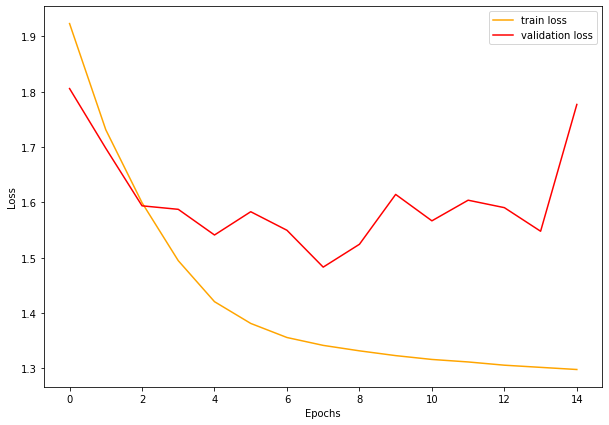

In [32]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss_1_clahe, color='orange', label='train loss')
plt.plot(valid_loss_1_clahe, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

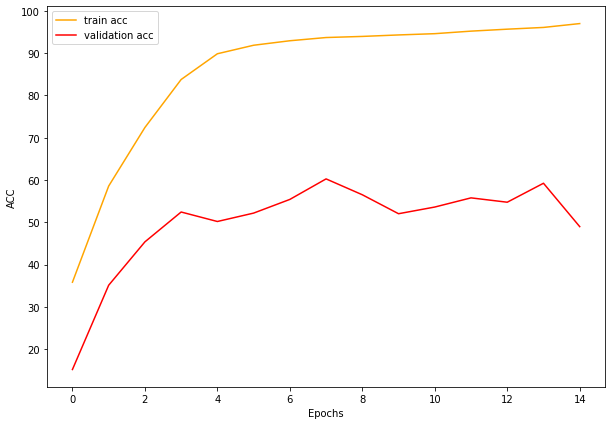

In [33]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_acc_1_clahe, color='orange', label='train acc')
plt.plot(valid_acc_1_clahe, color='red', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

In [34]:
for x, y in tqdm(valid_loader_1):
    x = x.to(device)
    y = y.to(device)
    out = model_1(x).to(device)
    print(out.data)
    print(y)

  0%|          | 0/43 [00:00<?, ?it/s]


NameError: name 'model_1' is not defined